In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4070 Ti


In [5]:
cd ..

/home/jovyan/ice_sleep_detpj


In [6]:
ls

 CITATION.cff                        feature_scaler_combined.pkl
 CONTRIBUTING.md                     feature_scaler_combined_4시.pkl
 LICENSE                             feature_scaler_combined_5_025.pkl
 README.md                           hubconf.py
 README.zh-CN.md                     ice_sleep_detpj/
'Untitled Folder'/                   models/
 __pycache__/                        pyproject.toml
 benchmarks.py                       requirements.txt
 best_model_lstm_combined.h5         runs/
 best_model_lstm_combined_4시.h5     segment/
 best_model_lstm_combined_5_025.h5   train.ipynb
 best_model_lstm_improved.h5         train.py
 best_model_lstm_ytrue.h5            train_lstm.ipynb
 classify/                           tutorial.ipynb
 copy_txt_to_yolo.py                 utils/
 data/                               val.py
 detect.py                           yolov5s.pt
 export.py


In [9]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
import os
import numpy as np
import joblib
from collections import defaultdict
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

CLASS_MAP = {
    0: "Leye_Open",
    1: "Leye_Closed", 
    2: "Reye_Open",
    3: "Reye_Closed",
    4: "Mouth_Open", 
    5: "Mouth_Closed"
}

# ✅ 1. YOLO .txt 한 개에서 feature 추출 (훈련 시와 동일한 특성)
def extract_feature_from_txt(txt_path):
    leye_open = reye_open = mouth_open = 0
    leye_area = reye_area = mouth_area = 0
    face_area = 0
    
    # YOLO 결과에서 face area 먼저 찾기 (얼굴이 가장 큰 박스라고 가정)
    all_detections = []
    
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
                
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:5])
            area = w * h
            all_detections.append((cls_id, area))
            
            # 가장 큰 area를 face_area로 설정
            if area > face_area:
                face_area = area
    
    # 각 부위별 정보 추출
    for cls_id, area in all_detections:
        label = CLASS_MAP.get(cls_id)
        if label == "Leye_Open":
            leye_open = 1
            leye_area = area
        elif label == "Leye_Closed":  
            leye_open = 0
            leye_area = area
        elif label == "Reye_Open":
            reye_open = 1
            reye_area = area  
        elif label == "Reye_Closed":
            reye_open = 0
            reye_area = area
        elif label == "Mouth_Open":
            mouth_open = 1
            mouth_area = area
        elif label == "Mouth_Closed":
            mouth_open = 0
            mouth_area = area
    
    # 훈련 시와 동일한 계산 방식 적용
    if face_area > 0:
        left_eye_ratio = leye_area / face_area
        right_eye_ratio = reye_area / face_area  
        mouth_ratio = mouth_area / face_area
        face_area_log = np.log(face_area + 1)  # 훈련 시와 동일하게 +1
    else:
        left_eye_ratio = right_eye_ratio = mouth_ratio = face_area_log = 0.0
    
    # 훈련 시와 정확히 동일한 순서로 반환
    return [
        float(leye_open),      # 0: left_eye_open
        float(reye_open),      # 1: right_eye_open  
        float(mouth_open),     # 2: mouth_open
        float(face_area_log),  # 3: face_area_log
        float(left_eye_ratio), # 4: left_eye_ratio (비율)
        float(right_eye_ratio),# 5: right_eye_ratio (비율)
        float(mouth_ratio)     # 6: mouth_ratio (비율)
    ]

# ✅ 2. 최근 30개 시퀀스로 예측
def predict_sequence(txt_files, model, scaler, seq_len=15):
    if len(txt_files) < seq_len:
        return None, None
    
    # 파일명 기준 정렬
    txt_files = sorted(txt_files)
    seq_files = txt_files[-seq_len:]  # 최근 30개
    
    # 특성 추출
    features = []
    for f in seq_files:
        try:
            feat = extract_feature_from_txt(f)
            if len(feat) != 7:  # 7개 특성 확인
                print(f"⚠️ 특성 개수 오류: {f} -> {len(feat)}개")
                return None, None
            features.append(feat)
        except Exception as e:
            print(f"❌ 파일 읽기 오류: {f} -> {e}")
            return None, None
    
    # numpy 배열로 변환 및 reshape
    X = np.array(features, dtype=np.float32).reshape(1, seq_len, 7)
    
    # 스케일링
    X_scaled = scaler.transform(X.reshape(-1, 7)).reshape(1, seq_len, 7)
    
    # 예측
    try:
        pred = model.predict(X_scaled, verbose=0)[0][0]
        result = "졸음 🛑" if pred > 0.5 else "정상 ✅"
        return float(pred), result
    except Exception as e:
        print(f"❌ 예측 오류: {e}")
        return None, None

# ✅ 여러 label_dir을 통합하여 평가하는 버전
def run_batch_prediction_multi_dirs(label_dirs, model_path, scaler_path, seq_len=30):
    print(f"📂 YOLO 결과 라벨 경로 (복수): {label_dirs}")
    
    # 모델 및 스케일러 로드
    try:
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        print(f"✅ 모델 로드 완료: {model_path}")
        print(f"✅ 스케일러 로드 완료: {scaler_path}")
    except Exception as e:
        print(f"❌ 모델/스케일러 로드 실패: {e}")
        return [], []

    # 통합된 person_groups 생성
    person_groups = defaultdict(list)

    for label_dir in label_dirs:
        if not os.path.exists(label_dir):
            print(f"❌ 라벨 디렉토리가 존재하지 않음: {label_dir}")
            continue
        for fname in os.listdir(label_dir):
            if fname.endswith('.txt'):
                base_id = "_".join(fname.split("_")[:2])
                person_groups[base_id].append(os.path.join(label_dir, fname))

    print(f"\n총 {len(person_groups)}명의 샘플 예측 시작...\n")
    
    y_probs = []
    y_ids = []

    for person_id, txt_files in sorted(person_groups.items()):
        pred, result = predict_sequence(txt_files, model, scaler, seq_len)
        if pred is None:
            print(f"{person_id}: ⚠️ 데이터 부족 또는 오류 (예측 생략)")
        else:
            print(f"{person_id}: 졸음 확률 {pred:.4f} → {result}")
            y_probs.append(pred)
            y_ids.append(person_id)

    return y_ids, y_probs


# ✅ 실행
if __name__ == "__main__":
    label_dir = "runs/detect/ice_yolo_test20_통제_train/labels"
    model_path = "best_model_lstm_combined.h5"
    scaler_path = "feature_scaler_combined.pkl"
    
    # 디버깅: 샘플 파일로 특성 추출 테스트
    sample_files = []
    if os.path.exists(label_dir):
        sample_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')][:3]
        
    if sample_files:
        print("🔍 샘플 파일 특성 추출 테스트:")
        for fname in sample_files:
            fpath = os.path.join(label_dir, fname)
            try:
                feat = extract_feature_from_txt(fpath)
                print(f"  {fname}: {len(feat)}개 특성")
                print(f"    특성값: {[f'{x:.4f}' for x in feat]}")
                print(f"    left_eye_open: {feat[0]}, right_eye_open: {feat[1]}, mouth_open: {feat[2]}")
                print(f"    face_area_log: {feat[3]:.4f}")
                print(f"    eye/mouth ratios: {feat[4]:.4f}, {feat[5]:.4f}, {feat[6]:.4f}")
            except Exception as e:
                print(f"  {fname}: 오류 -> {e}")
        print()
    
    # 훈련 시 특성 범위와 비교를 위한 참고값 출력
    print("📊 훈련 시 특성 범위 (참고):")
    print("  left_eye_open: 졸음=0.674, 정상=0.963")
    print("  right_eye_open: 졸음=0.638, 정상=0.926") 
    print("  mouth_open: 졸음=0.283, 정상=0.151")
    print("  face_area_log: 졸음=11.430, 정상=11.439")
    print("  ratios는 보통 0.02~0.04 범위")
    print()
    
    # 배치 예측 실행
    ids, probs = run_batch_prediction(label_dir, model_path, scaler_path)
    
    # 모델과 스케일러 정보 확인
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        try:
            model = load_model(model_path)
            scaler = joblib.load(scaler_path)
            print(f"🔍 모델 정보:")
            print(f"  입력 shape: {model.input_shape}")
            print(f"  스케일러 특성 수: {scaler.n_features_in_}")
            print(f"  스케일러 평균값: {scaler.mean_[:3]}... (처음 3개)")
            print(f"  스케일러 표준편차: {scaler.scale_[:3]}... (처음 3개)")
        except Exception as e:
            print(f"⚠️ 모델/스케일러 정보 확인 실패: {e}")
        print()
    
    # ✅ 예측 확률 분포 시각화
    if probs:
        plt.figure(figsize=(10, 6))
        plt.hist(probs, bins=30, alpha=0.7, edgecolor='black')
        plt.title(f"예측 확률 분포 (총 {len(probs)}개 샘플)", fontsize=14)
        plt.xlabel("졸음 확률", fontsize=12)
        plt.ylabel("샘플 수", fontsize=12)
        plt.axvline(x=0.5, color='red', linestyle='--', label='임계값 (0.5)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 통계 출력
        drowsy_count = sum(1 for p in probs if p > 0.5)
        normal_count = len(probs) - drowsy_count
        print(f"\n📊 예측 결과 요약:")
        print(f"  전체 샘플: {len(probs)}개")
        print(f"  졸음 예측: {drowsy_count}개 ({drowsy_count/len(probs)*100:.1f}%)")
        print(f"  정상 예측: {normal_count}개 ({normal_count/len(probs)*100:.1f}%)")
        print(f"  평균 확률: {np.mean(probs):.4f}")
        print(f"  표준편차: {np.std(probs):.4f}")
    else:
        print("❗ 예측 결과가 없어서 시각화를 생략합니다.")

🔍 샘플 파일 특성 추출 테스트:
  020_G1_08_좌측광원_룸미러_정상주시_20200922_193122_01979.txt: 7개 특성
    특성값: ['1.0000', '1.0000', '0.0000', '0.0031', '0.6632', '0.4408', '1.0000']
    left_eye_open: 1.0, right_eye_open: 1.0, mouth_open: 0.0
    face_area_log: 0.0031
    eye/mouth ratios: 0.6632, 0.4408, 1.0000
  011_G1_09_좌측광원_정면_정상주시_20200918_202208_00003.txt: 7개 특성
    특성값: ['1.0000', '1.0000', '0.0000', '0.0020', '0.9697', '1.0000', '0.0000']
    left_eye_open: 1.0, right_eye_open: 1.0, mouth_open: 0.0
    face_area_log: 0.0020
    eye/mouth ratios: 0.9697, 1.0000, 0.0000
  002_G1_01_무광원_룸미러_정상주시_20200917_192745_03081.txt: 7개 특성
    특성값: ['1.0000', '1.0000', '0.0000', '0.0020', '0.8680', '0.7697', '1.0000']
    left_eye_open: 1.0, right_eye_open: 1.0, mouth_open: 0.0
    face_area_log: 0.0020
    eye/mouth ratios: 0.8680, 0.7697, 1.0000

📊 훈련 시 특성 범위 (참고):
  left_eye_open: 졸음=0.674, 정상=0.963
  right_eye_open: 졸음=0.638, 정상=0.926
  mouth_open: 졸음=0.283, 정상=0.151
  face_area_log: 졸음=11.430, 정상=11.439
  rati

NameError: name 'run_batch_prediction' is not defined

In [2]:
rm -rf data/ice_lstm_seq/

In [6]:
files = sorted([f for f in os.listdir(label_dir) if f.startswith("045_G1") and f.endswith(".txt")])
for f in files[-30:]:
    print(f, extract_feature_from_txt(os.path.join(label_dir, f)))


045_G1_14_후면광원_룸미러_통화재현_20200929_114151_01953.txt [1, 1, 0, 0.0, 0.00150390625, 0.0008906249999999999, 0.003695318]
045_G1_14_후면광원_룸미러_통화재현_20200929_114151_01956.txt [1, 1, 0, 0.0, 0.00144921875, 0.0008085915, 0.003568359375]
045_G1_14_후면광원_썬바이저_정상주시_20200929_114151_00781.txt [1, 1, 0, 0.0, 0.001728515625, 0.0018457031250000001, 0.004554687500000001]
045_G1_14_후면광원_썬바이저_정상주시_20200929_114151_00784.txt [1, 1, 0, 0.0, 0.0018466758749999999, 0.00187694925, 0.004554687500000001]
045_G1_14_후면광원_썬바이저_통화재현_20200929_114151_00924.txt [1, 1, 1, 0.0, 0.001786129125, 0.00196875, 0.0052734375]
045_G1_14_후면광원_썬바이저_통화재현_20200929_114151_00927.txt [1, 1, 1, 0.0, 0.0018164025, 0.001907222625, 0.004716796875]
045_G1_14_후면광원_우사이드미러_정상주시_20200929_114151_01118.txt [0, 0, 0, 0.0, 0, 0, 0.002882808]
045_G1_14_후면광원_우사이드미러_정상주시_20200929_114151_01121.txt [0, 0, 0, 0.0, 0, 0, 0.0028125]
045_G1_14_후면광원_우사이드미러_통화재현_20200929_114151_01264.txt [0, 0, 1, 0.0, 0, 0, 0.003548828125]
045_G1_14_후면광원_우사이드미러_통화재현_20200929_114

In [13]:
# 눈 감은 프레임 수 확인
X_train = np.load("data/ice_lstm_seq_combined_ytrue/X_seq.npy")
y_train = np.load("data/ice_lstm_seq_combined_ytrue/y_seq.npy")

open_stat = X_train[:, :, :2].reshape(-1, 2)  # leye_open, reye_open만
both_closed = np.sum((open_stat[:, 0] == 0) & (open_stat[:, 1] == 0))
total = len(open_stat)
print(f"👁️ 눈 감은 프레임 수: {both_closed} / {total} ({100 * both_closed/total:.2f}%)")


👁️ 눈 감은 프레임 수: 889225 / 4776810 (18.62%)


📊 예측 확률:
Q_098 | 실제: 1 | 예측 확률: 0.2881
Q_099 | 실제: 1 | 예측 확률: 0.6640
Q_100 | 실제: 1 | 예측 확률: 0.1306
Q_101 | 실제: 1 | 예측 확률: 0.6787
Q_102 | 실제: 1 | 예측 확률: 0.8103
Q_103 | 실제: 1 | 예측 확률: 0.8409
Q_104 | 실제: 1 | 예측 확률: 0.8117
Q_105 | 실제: 1 | 예측 확률: 0.2345
Q_106 | 실제: 1 | 예측 확률: 0.0819
Q_107 | 실제: 0 | 예측 확률: 0.0762
Q_108 | 실제: 1 | 예측 확률: 0.3625
R_332 | 실제: 0 | 예측 확률: 0.0002
R_333 | 실제: 0 | 예측 확률: 0.0000
R_334 | 실제: 0 | 예측 확률: 0.0000
R_335 | 실제: 0 | 예측 확률: 0.0637
R_336 | 실제: 0 | 예측 확률: 0.0999
R_337 | 실제: 0 | 예측 확률: 0.0000
R_338 | 실제: 0 | 예측 확률: 0.6233
R_339 | 실제: 0 | 예측 확률: 0.1281


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


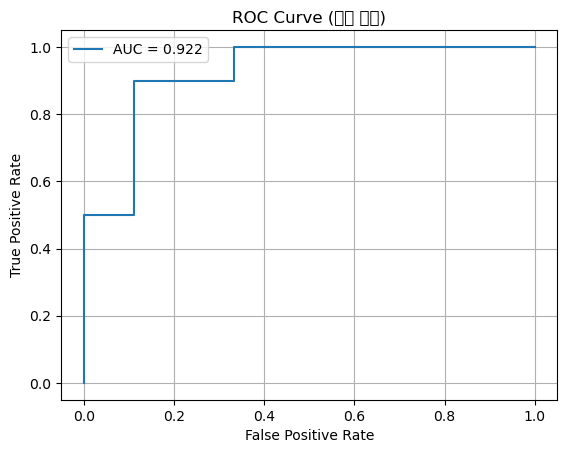

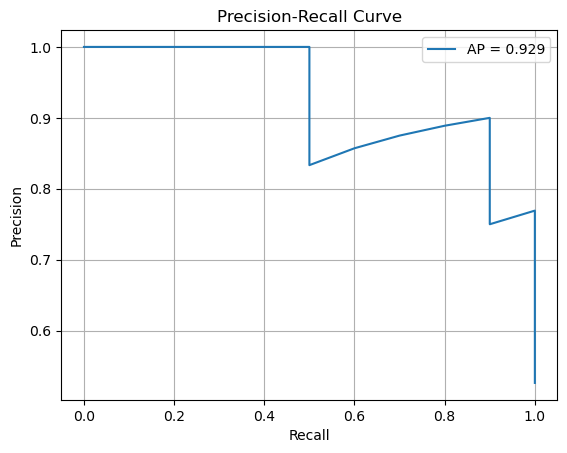

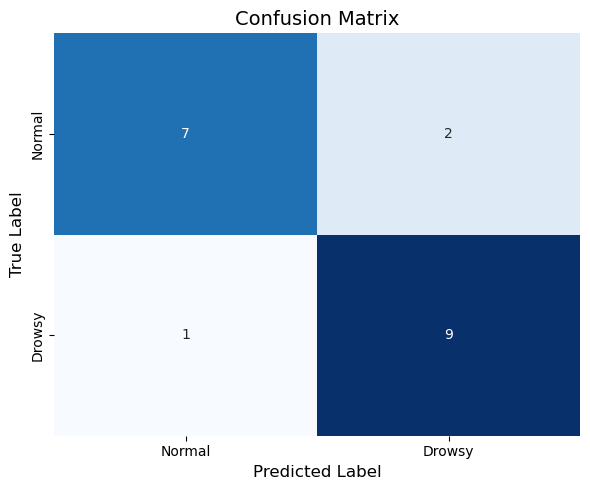

Confusion Matrix:
[[7 2]
 [1 9]]

Classification Report:
              precision    recall  f1-score   support

           0      0.875     0.778     0.824         9
           1      0.818     0.900     0.857        10

    accuracy                          0.842        19
   macro avg      0.847     0.839     0.840        19
weighted avg      0.845     0.842     0.841        19



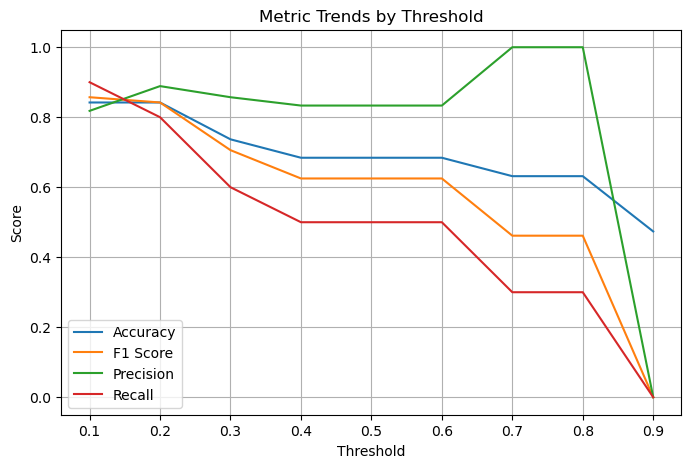

In [16]:
import os
import numpy as np
import joblib
from collections import defaultdict
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 🔧 클래스 맵 (YOLO 클래스 ID → 라벨)
CLASS_MAP = {
    0: "Leye_Open",
    1: "Leye_Closed",
    2: "Reye_Open",
    3: "Reye_Closed",
    4: "Mouth_Open",
    5: "Mouth_Closed"
}

# ✅ YOLO .txt에서 feature 추출
def extract_feature_from_txt(txt_path):
    leye_open = reye_open = mouth_open = 0
    leye_area = reye_area = mouth_area = 0

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:5])
            area = w * h

            label = CLASS_MAP.get(cls_id)
            if label == "Leye_Open": leye_open = 1; leye_area = area
            elif label == "Leye_Closed": leye_open = 0; leye_area = area
            elif label == "Reye_Open": reye_open = 1; reye_area = area
            elif label == "Reye_Closed": reye_open = 0; reye_area = area
            elif label == "Mouth_Open": mouth_open = 1; mouth_area = area
            elif label == "Mouth_Closed": mouth_open = 0; mouth_area = area

    return [leye_open, reye_open, mouth_open, 0.0, leye_area, reye_area, mouth_area]

# ✅ 시퀀스 예측
def predict_sequence(txt_file_list, model, scaler, seq_len=30):
    if len(txt_file_list) < seq_len:
        return None

    txt_file_list = sorted(txt_file_list)
    seq_files = txt_file_list[-seq_len:]
    features = [extract_feature_from_txt(f) for f in seq_files]
    X = np.array(features).reshape(1, seq_len, 7)

    binary_idx = scaler.binary_features_
    continuous_idx = scaler.continuous_features_

    X_scaled = X.copy()
    continuous = X[:, :, continuous_idx].reshape(-1, len(continuous_idx))
    continuous_scaled = scaler.transform(continuous)
    X_scaled[:, :, continuous_idx] = continuous_scaled.reshape(1, seq_len, len(continuous_idx))

    pred_prob = model.predict(X_scaled, verbose=0)[0][0]
    return pred_prob

# ✅ 여러 폴더 대상 평가
def evaluate_model_with_labels_multi(label_dirs, model_path, scaler_path, label_map, seq_len=30):
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    person_groups = defaultdict(list)
    for label_dir in label_dirs:
        for fname in os.listdir(label_dir):
            if fname.endswith('.txt'):
                base_id = "_".join(fname.split("_")[:2])
                person_groups[base_id].append(os.path.join(label_dir, fname))

    y_true, y_score = [], []

    print("📊 예측 확률:")
    for person_id in sorted(label_map.keys()):
        if person_id not in person_groups:
            print(f"⚠️ {person_id} 에 해당하는 .txt 파일 없음 → 생략")
            continue

        txt_files = person_groups[person_id]
        pred = predict_sequence(txt_files, model, scaler, seq_len=seq_len)

        if pred is not None:
            y_true.append(label_map[person_id])
            y_score.append(pred)
            print(f"{person_id} | 실제: {label_map[person_id]} | 예측 확률: {pred:.4f}")
        else:
            print(f"{person_id} | 예측 실패 (데이터 부족 또는 오류)")

    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, y_true, y_score

# ✅ 혼동 행렬 출력 함수
def plot_confusion_matrix(y_true, y_pred, labels=["Normal", "Drowsy"], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ 평가 대상 설정
label_dirs = [
    "runs/detect/ice_yolo_test20_준통제/labels",
    "runs/detect/ice_yolo_test20_실도환_택시_val/labels"
]
model_path = "best_model_lstm_combined_4시.h5"
scaler_path = "feature_scaler_combined_4시.pkl"
label_map = {
    # 졸음 (준통제 환경)
    "Q_098": 1, "Q_099": 1, "Q_100": 1, "Q_101": 1,
    "Q_102": 1, "Q_103": 1, "Q_104": 1, "Q_105": 1,
    "Q_106": 1, "Q_107": 0, "Q_108": 1,
    # 비졸음 (실제도로 환경)
    "R_332": 0, "R_333": 0, "R_334": 0, "R_335": 0,
    "R_336": 0, "R_337": 0, "R_338": 0, "R_339": 0
}

# ✅ 평가 실행
fpr, tpr, roc_auc, y_true, y_score = evaluate_model_with_labels_multi(
    label_dirs, model_path, scaler_path, label_map
)

# ✅ ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (통합 평가)")
plt.grid(True)
plt.legend()
plt.show()

# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# ✅ Confusion Matrix
y_pred = (y_score > 0.1).astype(int)
plot_confusion_matrix(y_true, y_pred)

# ✅ 텍스트 리포트
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))


# ✅ threshold별 metric 분석 추가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 1.0, 0.1)
acc_list, pre_list, rec_list, f1_list = [], [], [], []

for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    acc_list.append(accuracy_score(y_true, y_pred))
    pre_list.append(precision_score(y_true, y_pred, zero_division=0))
    rec_list.append(recall_score(y_true, y_pred, zero_division=0))
    f1_list.append(f1_score(y_true, y_pred, zero_division=0))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, acc_list, label="Accuracy")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.plot(thresholds, pre_list, label="Precision")
plt.plot(thresholds, rec_list, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Trends by Threshold")
plt.legend()
plt.grid(True)
plt.show()



📊 예측 확률:
Q_098 | 실제: 1 | 예측 확률: 0.2881
Q_099 | 실제: 1 | 예측 확률: 0.6640
Q_100 | 실제: 1 | 예측 확률: 0.1306
Q_101 | 실제: 1 | 예측 확률: 0.6787
Q_102 | 실제: 1 | 예측 확률: 0.8103
Q_103 | 실제: 1 | 예측 확률: 0.8409
Q_104 | 실제: 1 | 예측 확률: 0.8117
Q_105 | 실제: 1 | 예측 확률: 0.2345
Q_106 | 실제: 1 | 예측 확률: 0.0819
Q_107 | 실제: 0 | 예측 확률: 0.0762
Q_108 | 실제: 1 | 예측 확률: 0.3625
R_332 | 실제: 0 | 예측 확률: 0.0002
R_333 | 실제: 0 | 예측 확률: 0.0000
R_334 | 실제: 0 | 예측 확률: 0.0000
R_335 | 실제: 0 | 예측 확률: 0.0637
R_336 | 실제: 0 | 예측 확률: 0.0999
R_337 | 실제: 0 | 예측 확률: 0.0000
R_338 | 실제: 0 | 예측 확률: 0.6233
R_339 | 실제: 0 | 예측 확률: 0.1281


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


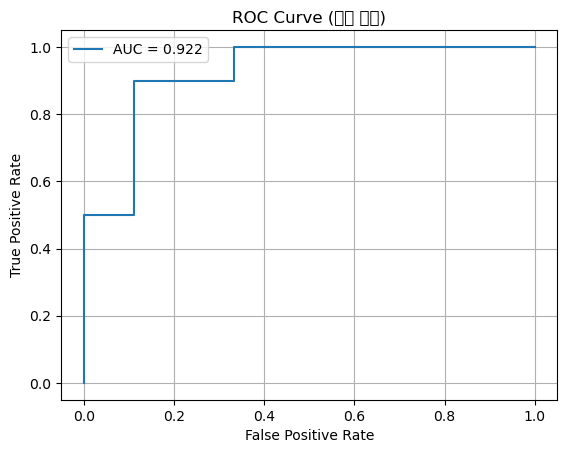

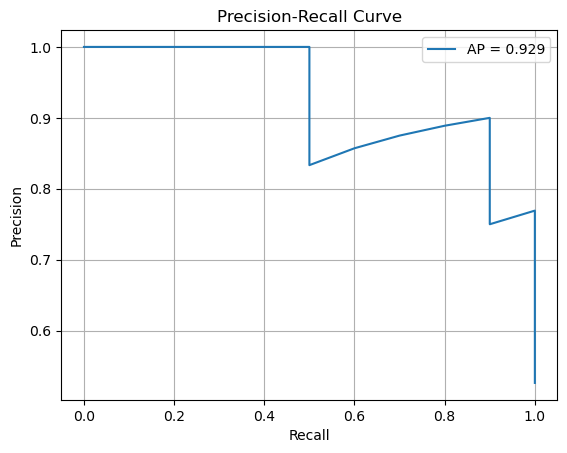

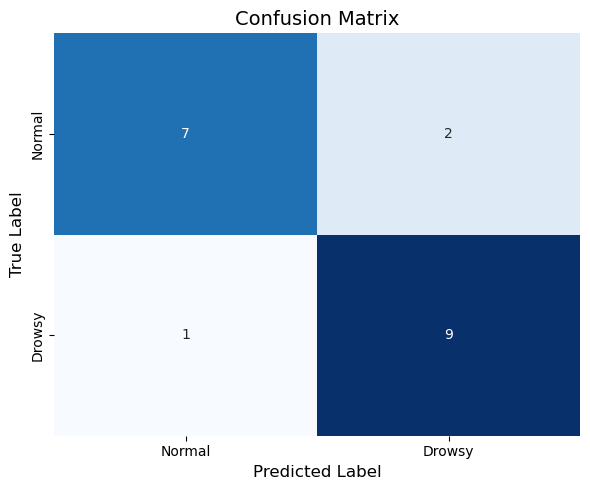

Confusion Matrix:
[[7 2]
 [1 9]]

Classification Report:
              precision    recall  f1-score   support

           0      0.875     0.778     0.824         9
           1      0.818     0.900     0.857        10

    accuracy                          0.842        19
   macro avg      0.847     0.839     0.840        19
weighted avg      0.845     0.842     0.841        19



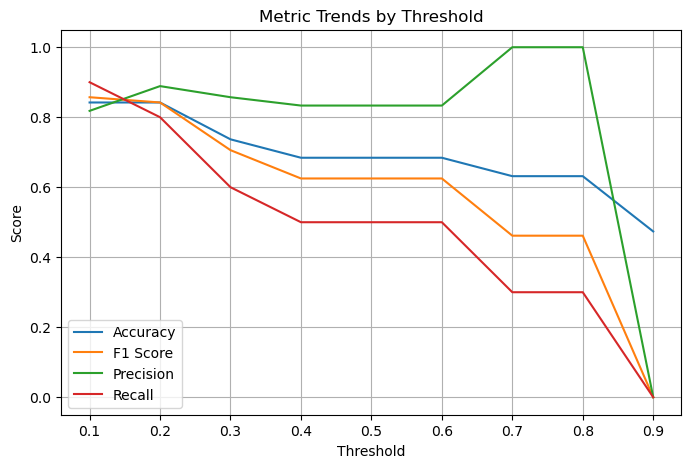

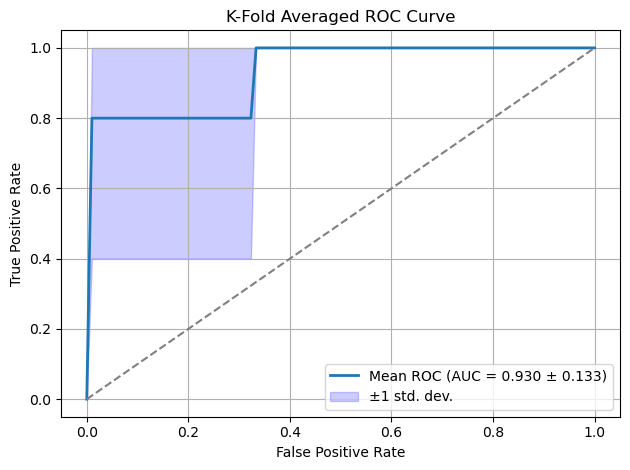

In [17]:
import os
import numpy as np
import joblib
from collections import defaultdict
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 🔧 클래스 맵 (YOLO 클래스 ID → 라벨)
CLASS_MAP = {
    0: "Leye_Open",
    1: "Leye_Closed",
    2: "Reye_Open",
    3: "Reye_Closed",
    4: "Mouth_Open",
    5: "Mouth_Closed"
}

# ✅ YOLO .txt에서 feature 추출
def extract_feature_from_txt(txt_path):
    leye_open = reye_open = mouth_open = 0
    leye_area = reye_area = mouth_area = 0

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:5])
            area = w * h

            label = CLASS_MAP.get(cls_id)
            if label == "Leye_Open": leye_open = 1; leye_area = area
            elif label == "Leye_Closed": leye_open = 0; leye_area = area
            elif label == "Reye_Open": reye_open = 1; reye_area = area
            elif label == "Reye_Closed": reye_open = 0; reye_area = area
            elif label == "Mouth_Open": mouth_open = 1; mouth_area = area
            elif label == "Mouth_Closed": mouth_open = 0; mouth_area = area

    return [leye_open, reye_open, mouth_open, 0.0, leye_area, reye_area, mouth_area]

# ✅ 시퀀스 예측
def predict_sequence(txt_file_list, model, scaler, seq_len=30):
    if len(txt_file_list) < seq_len:
        return None

    txt_file_list = sorted(txt_file_list)
    seq_files = txt_file_list[-seq_len:]
    features = [extract_feature_from_txt(f) for f in seq_files]
    X = np.array(features).reshape(1, seq_len, 7)

    binary_idx = scaler.binary_features_
    continuous_idx = scaler.continuous_features_

    X_scaled = X.copy()
    continuous = X[:, :, continuous_idx].reshape(-1, len(continuous_idx))
    continuous_scaled = scaler.transform(continuous)
    X_scaled[:, :, continuous_idx] = continuous_scaled.reshape(1, seq_len, len(continuous_idx))

    pred_prob = model.predict(X_scaled, verbose=0)[0][0]
    return pred_prob

# ✅ 여러 폴더 대상 평가
def evaluate_model_with_labels_multi(label_dirs, model_path, scaler_path, label_map, seq_len=30):
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    person_groups = defaultdict(list)
    for label_dir in label_dirs:
        for fname in os.listdir(label_dir):
            if fname.endswith('.txt'):
                base_id = "_".join(fname.split("_")[:2])
                person_groups[base_id].append(os.path.join(label_dir, fname))

    y_true, y_score = [], []

    print("📊 예측 확률:")
    for person_id in sorted(label_map.keys()):
        if person_id not in person_groups:
            print(f"⚠️ {person_id} 에 해당하는 .txt 파일 없음 → 생략")
            continue

        txt_files = person_groups[person_id]
        pred = predict_sequence(txt_files, model, scaler, seq_len=seq_len)

        if pred is not None:
            y_true.append(label_map[person_id])
            y_score.append(pred)
            print(f"{person_id} | 실제: {label_map[person_id]} | 예측 확률: {pred:.4f}")
        else:
            print(f"{person_id} | 예측 실패 (데이터 부족 또는 오류)")

    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, y_true, y_score

# ✅ 혼동 행렬 출력 함수
def plot_confusion_matrix(y_true, y_pred, labels=["Normal", "Drowsy"], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ 평가 대상 설정
label_dirs = [
    "runs/detect/ice_yolo_test20_준통제/labels",
    "runs/detect/ice_yolo_test20_실도환_택시_val/labels"
]
model_path = "best_model_lstm_combined_4시.h5"
scaler_path = "feature_scaler_combined_4시.pkl"
label_map = {
    # 졸음 (준통제 환경)
    "Q_098": 1, "Q_099": 1, "Q_100": 1, "Q_101": 1,
    "Q_102": 1, "Q_103": 1, "Q_104": 1, "Q_105": 1,
    "Q_106": 1, "Q_107": 0, "Q_108": 1,
    # 비졸음 (실제도로 환경)
    "R_332": 0, "R_333": 0, "R_334": 0, "R_335": 0,
    "R_336": 0, "R_337": 0, "R_338": 0, "R_339": 0
}

# ✅ 모델 평가
fpr, tpr, roc_auc, y_true, y_score = evaluate_model_with_labels_multi(
    label_dirs, model_path, scaler_path, label_map
)

# ✅ ROC Curve
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (통합 평가)")
plt.grid(True)
plt.legend()
plt.show()

# ✅ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# ✅ Confusion Matrix
y_pred = (y_score > 0.1).astype(int)
plot_confusion_matrix(y_true, y_pred)

# ✅ 텍스트 리포트
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

# ✅ threshold별 metric 분석 추가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 1.0, 0.1)
acc_list, pre_list, rec_list, f1_list = [], [], [], []

for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    acc_list.append(accuracy_score(y_true, y_pred))
    pre_list.append(precision_score(y_true, y_pred, zero_division=0))
    rec_list.append(recall_score(y_true, y_pred, zero_division=0))
    f1_list.append(f1_score(y_true, y_pred, zero_division=0))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, acc_list, label="Accuracy")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.plot(thresholds, pre_list, label="Precision")
plt.plot(thresholds, rec_list, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Trends by Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ✅ k-fold ROC curve 함수 정의
from sklearn.model_selection import KFold

def plot_kfold_roc(y_true, y_score, n_splits=5):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    mean_fpr = np.linspace(0, 1, 100)

    tprs = []
    aucs = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(y_score):
        fpr, tpr, _ = roc_curve(y_true[test_idx], y_score[test_idx])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})", lw=2)
    plt.fill_between(mean_fpr,
                     np.maximum(mean_tpr - np.std(tprs, axis=0), 0),
                     np.minimum(mean_tpr + np.std(tprs, axis=0), 1),
                     alpha=0.2, color='blue', label="±1 std. dev.")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("K-Fold Averaged ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 🔧 여기 함수 호출만 수정됨!
plot_kfold_roc(y_true, y_score, n_splits=5)


📊 예측 확률:
Q_098 | 실제: 1 | 예측 확률: 0.0000
Q_099 | 실제: 1 | 예측 확률: 0.9727
Q_100 | 실제: 1 | 예측 확률: 0.0000
Q_101 | 실제: 1 | 예측 확률: 0.9701
Q_102 | 실제: 1 | 예측 확률: 0.9710
Q_103 | 실제: 1 | 예측 확률: 0.9705
Q_104 | 실제: 1 | 예측 확률: 0.9709
Q_105 | 실제: 1 | 예측 확률: 0.0005
Q_106 | 실제: 1 | 예측 확률: 0.0000
Q_107 | 실제: 0 | 예측 확률: 0.0000
Q_108 | 실제: 1 | 예측 확률: 0.0000
R_332 | 실제: 0 | 예측 확률: 0.0000
R_333 | 실제: 0 | 예측 확률: 0.0000
R_334 | 실제: 0 | 예측 확률: 0.0000
R_335 | 실제: 0 | 예측 확률: 0.0000
R_336 | 실제: 0 | 예측 확률: 0.0000
R_337 | 실제: 0 | 예측 확률: 0.0000
R_338 | 실제: 0 | 예측 확률: 0.9747
R_339 | 실제: 0 | 예측 확률: 0.0000


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


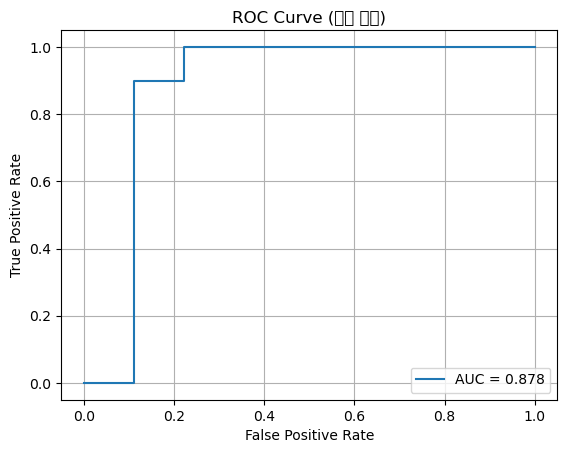

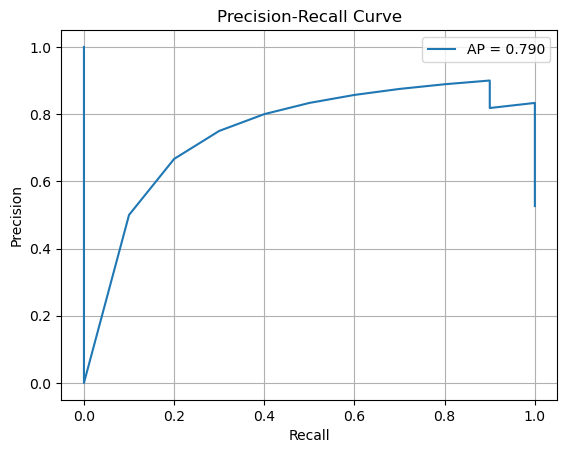

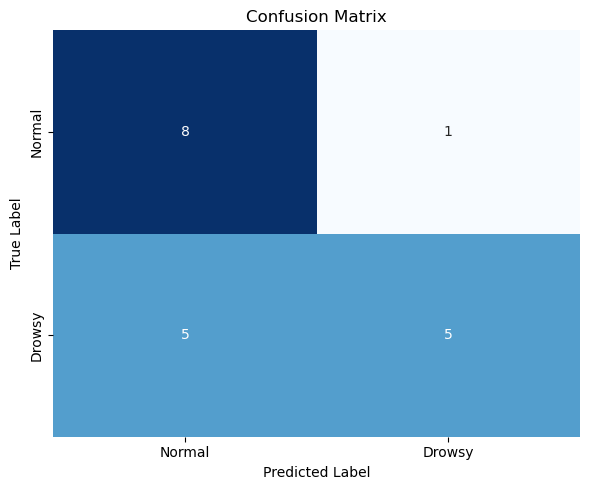

Confusion Matrix:
[[8 1]
 [5 5]]

Classification Report:
              precision    recall  f1-score   support

           0      0.615     0.889     0.727         9
           1      0.833     0.500     0.625        10

    accuracy                          0.684        19
   macro avg      0.724     0.694     0.676        19
weighted avg      0.730     0.684     0.673        19



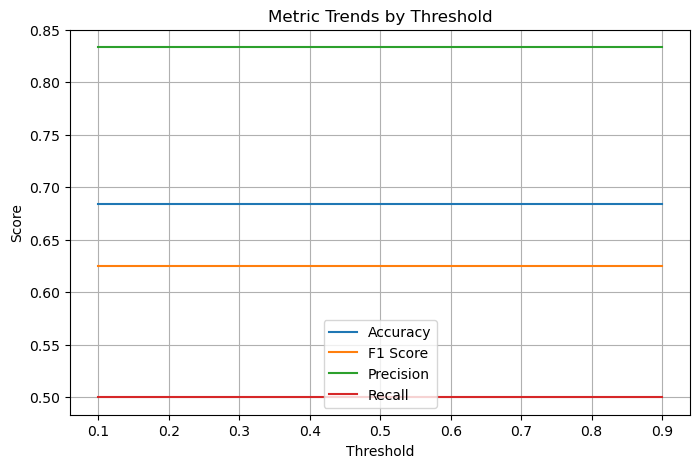

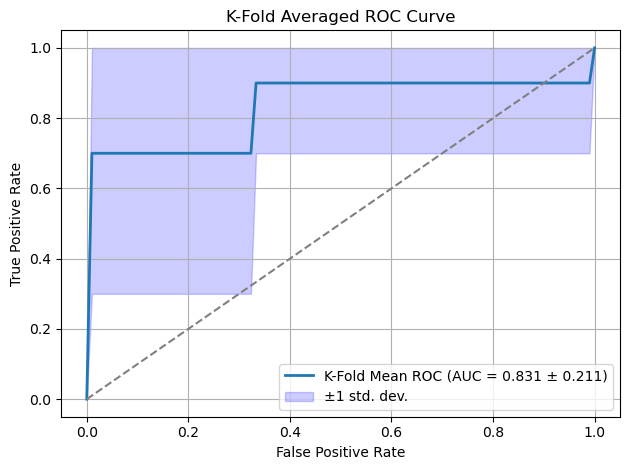

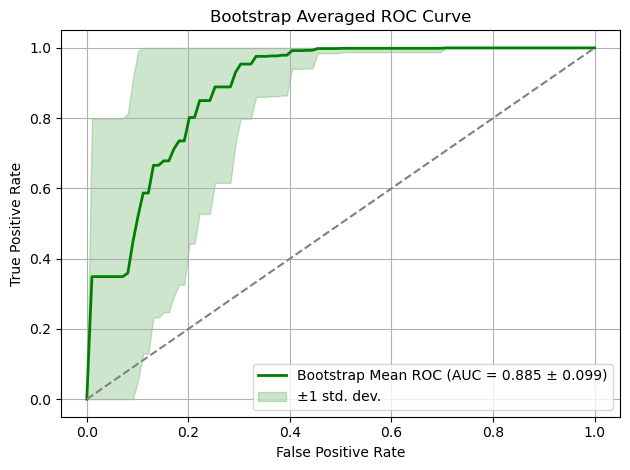

In [4]:
# 부트스트랩
import os
import numpy as np
import joblib
from collections import defaultdict
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
import seaborn as sns

# 🔧 클래스 맵 (YOLO 클래스 ID → 라벨)
CLASS_MAP = {
    0: "Leye_Open",
    1: "Leye_Closed",
    2: "Reye_Open",
    3: "Reye_Closed",
    4: "Mouth_Open",
    5: "Mouth_Closed"
}

def extract_feature_from_txt(txt_path):
    leye_open = reye_open = mouth_open = 0
    leye_area = reye_area = mouth_area = 0
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = int(parts[0])
            x, y, w, h = map(float, parts[1:5])
            area = w * h
            label = CLASS_MAP.get(cls_id)
            if label == "Leye_Open": leye_open = 1; leye_area = area
            elif label == "Leye_Closed": leye_open = 0; leye_area = area
            elif label == "Reye_Open": reye_open = 1; reye_area = area
            elif label == "Reye_Closed": reye_open = 0; reye_area = area
            elif label == "Mouth_Open": mouth_open = 1; mouth_area = area
            elif label == "Mouth_Closed": mouth_open = 0; mouth_area = area
    return [leye_open, reye_open, mouth_open, 0.0, leye_area, reye_area, mouth_area]

def predict_sequence(txt_file_list, model, scaler, seq_len=30):
    if len(txt_file_list) < seq_len:
        return None
    txt_file_list = sorted(txt_file_list)
    seq_files = txt_file_list[-seq_len:]
    features = [extract_feature_from_txt(f) for f in seq_files]
    X = np.array(features).reshape(1, seq_len, 7)
    binary_idx = scaler.binary_features_
    continuous_idx = scaler.continuous_features_
    X_scaled = X.copy()
    continuous = X[:, :, continuous_idx].reshape(-1, len(continuous_idx))
    continuous_scaled = scaler.transform(continuous)
    X_scaled[:, :, continuous_idx] = continuous_scaled.reshape(1, seq_len, len(continuous_idx))
    pred_prob = model.predict(X_scaled, verbose=0)[0][0]
    return pred_prob

def evaluate_model_with_labels_multi(label_dirs, model_path, scaler_path, label_map, seq_len=16):
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    person_groups = defaultdict(list)
    for label_dir in label_dirs:
        for fname in os.listdir(label_dir):
            if fname.endswith('.txt'):
                base_id = "_".join(fname.split("_")[:2])
                person_groups[base_id].append(os.path.join(label_dir, fname))
    y_true, y_score = [], []
    print("📊 예측 확률:")
    for person_id in sorted(label_map.keys()):
        if person_id not in person_groups:
            print(f"⚠️ {person_id} 에 해당하는 .txt 파일 없음 → 생략")
            continue
        txt_files = person_groups[person_id]
        pred = predict_sequence(txt_files, model, scaler, seq_len=seq_len)
        if pred is not None:
            y_true.append(label_map[person_id])
            y_score.append(pred)
            print(f"{person_id} | 실제: {label_map[person_id]} | 예측 확률: {pred:.4f}")
        else:
            print(f"{person_id} | 예측 실패 (데이터 부족 또는 오류)")
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, y_true, y_score

def plot_confusion_matrix(y_true, y_pred, labels=["Normal", "Drowsy"], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_kfold_roc(y_true, y_score, n_splits=5):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(y_true):  # 🔧 수정된 부분
        fpr, tpr, _ = roc_curve(y_true[test_idx], y_score[test_idx])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f"K-Fold Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})", lw=2)
    plt.fill_between(mean_fpr, np.maximum(mean_tpr - np.std(tprs, axis=0), 0), np.minimum(mean_tpr + np.std(tprs, axis=0), 1), alpha=0.2, color='blue', label="±1 std. dev.")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("K-Fold Averaged ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_bootstrap_roc(y_true, y_score, n_bootstraps=100, random_seed=42):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    rng = np.random.RandomState(random_seed)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[indices], y_score[indices])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # 시작점 고정
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    tprs = np.array(tprs)
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f"Bootstrap Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})", lw=2, color='green')
    plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), alpha=0.2, color='green', label="±1 std. dev.")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Bootstrap Averaged ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 설정
label_dirs = [
    "runs/detect/ice_yolo_test20_준통제/labels",
    "runs/detect/ice_yolo_test20_실도환_택시_val/labels"
]
model_path = "best_model_lstm_combined_0604.h5" #0604: 0.878
scaler_path = "feature_scaler_combined_0604.pkl"# best_model_lstm_improved
label_map = {
    "Q_098": 1, "Q_099": 1, "Q_100": 1, "Q_101": 1,
    "Q_102": 1, "Q_103": 1, "Q_104": 1, "Q_105": 1,
    "Q_106": 1, "Q_107": 0, "Q_108": 1,
    "R_332": 0, "R_333": 0, "R_334": 0, "R_335": 0,
    "R_336": 0, "R_337": 0, "R_338": 0, "R_339": 0
}

# ✅ 평가
fpr, tpr, roc_auc, y_true, y_score = evaluate_model_with_labels_multi(
    label_dirs, model_path, scaler_path, label_map
)

# ✅ 기본 ROC
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (통합 평가)")
plt.grid(True)
plt.legend()
plt.show()

# ✅ PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# ✅ Confusion Matrix
y_pred = (y_score > 0.5).astype(int)
plot_confusion_matrix(y_true, y_pred)

# ✅ Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

# ✅ Threshold 별 Metric 시각화
thresholds = np.arange(0.1, 1.0, 0.1)
acc_list, pre_list, rec_list, f1_list = [], [], [], []
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    acc_list.append(accuracy_score(y_true, y_pred))
    pre_list.append(precision_score(y_true, y_pred, zero_division=0))
    rec_list.append(recall_score(y_true, y_pred, zero_division=0))
    f1_list.append(f1_score(y_true, y_pred, zero_division=0))
plt.figure(figsize=(8, 5))
plt.plot(thresholds, acc_list, label="Accuracy")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.plot(thresholds, pre_list, label="Precision")
plt.plot(thresholds, rec_list, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Trends by Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ✅ K-Fold ROC
plot_kfold_roc(y_true, y_score, n_splits=5)

# ✅ Bootstrap ROC
plot_bootstrap_roc(y_true, y_score, n_bootstraps=100)
